In [57]:
# SETUP
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd

Q1_QRELS_FILE = "../query_qrels_M3/query_1.txt"
Q2_QRELS_FILE = "../query_qrels_M3/query_2.txt"
Q3_QRELS_FILE = "../query_qrels_M3/query_3.txt"



#System 1 and 2 (lucene)
Q1 = "http://localhost:8983/solr/medicines/select?defType=lucene&indent=true&q.op=OR&q=(Antes_de_utilizar%3Aamamentar~3%20AND%20(Antes_de_utilizar%3A%22amamentação%20Não%22~4))%20OR%20(Antes_de_utilizar%3Agravidez%20AND%20(Antes_de_utilizar%3A%22grávida%20Não%22%5E2~4))&rows=100&useParams=&wt=json"
Q2 = "http://localhost:8983/solr/medicines/select?defType=lucene&indent=true&q.op=OR&q=Substancia_Ativa_DCI%3ABioflavonóides%20%20AND%20(O_que_e_e_para_que_e_utilizado%3Aprotet*%20vascular%20OR%20O_que_e_e_para_que_e_utilizado%3A%20protege~1%20as%20veias)&rows=100&useParams=&wt=json"
Q3 = "http://localhost:8983/solr/medicines/select?defType=lucene&indent=true&q.op=OR&q=O_que_e_e_para_que_e_utilizado%3A%22alivio%20dores%22~2%20AND%20Vias_de_Administracao%3A%22oral%22&rows=100&useParams=&wt=json"


#Systen 3
Q1_3 = "http://localhost:8983/solr/medicines/select?defType=edismax&indent=true&q.op=OR&q=(Antes_de_utilizar%3Aamamentar~3%20AND%20(Antes_de_utilizar%3A%22amamentação%20Não%22~4))%20OR%20(Antes_de_utilizar%3Aaleitamento%20AND%20(Antes_de_utilizar%3A%22aleitamento%20Não%22~4))%20OR%20(Antes_de_utilizar%3Agravidez%20AND%20(Antes_de_utilizar%3A%22grávida%20Não%22%5E2~4))&qf=Product_name%5E5%20Substancia_Ativa_DCI%5E4%20O_que_e_e_para_que_e_utilizado%5E2%20Antes_de_utilizar%5E2&rows=100&useParams=&wt=json"

QUERY_URL = Q1
QRELS_FILE = Q1_QRELS_FILE

In [58]:
# Read qrels to extract relevant documents
relevant = list(map(lambda el: el.strip(), open(QRELS_FILE).readlines()))
# Get query results from Solr instance
results = requests.get(QUERY_URL).json()['response']['docs']

print(results)
print('Returned:',len(results))

[{'Product_name': ['Clopidogrel Generis Phar'], 'Active_substance': 'Clopidogrel Besilate', 'Route_of_administration': 'Oral Use', 'Product_authorisation_country': 'Portugal', 'Marketing_authorisation_holder': 'Generis Phar, Unipessoal Lda.', 'Pharmacovigilance_system_master_file_location': 'Malta', 'Pharmacovigilance_enquiries_email_address': 'pharmacovigilance.eu@aurobindo.com', 'Pharmacovigilance_enquiries_telephone_number': '+356 222 94000', 'Lowest_PVP': '9.62', 'Substancia_Ativa_DCI': 'Clopidogrel', 'Forma_Farmaceutica': 'Comprimido revestido por película', 'Dosagem': '75 mg', 'Titular_de_AIM': 'Generis Phar, Unipessoal Lda.', 'Generico': 'Sim', 'Vias_de_Administracao': 'Via oral', 'Grupo_de_Produto': 'Genérico', 'Numero_de_Processo': '08/H/0309/001', 'AIM': 'Autorizado', 'Data': '26/06/2009', 'Classificacao_Quanto_a_Dispensa': 'MSRM', 'Duracao_do_Tratamento': 'Longa Duração', 'O_que_e_e_para_que_e_utilizado': 'O que é Clopidogrel Generis Phar e para que é utilizado\nClopidogrel 

In [59]:
# METRICS TABLE
# Define custom decorator to automatically calculate metric based on key
metrics = {}
metric = lambda f: metrics.setdefault(f.__name__, f)

@metric
def ap(results, relevant):
    """Average Precision"""
    precision_values = []
    relevant_count = 0

    for idx, doc in enumerate(results):
        if doc['Product_name'][0] in relevant:
            relevant_count += 1
            precision_at_k = relevant_count / (idx + 1)
            precision_values.append(precision_at_k)

    if not precision_values:
        return 0.0

    return sum(precision_values)/len(precision_values)

@metric
def p10(results, relevant, n=10):
    """Precision at N"""
    return len([doc for doc in results[:n] if doc['Product_name'][0] in relevant])/n

def calculate_metric(key, results, relevant):
    return metrics[key](results, relevant)

# Define metrics to be calculated
evaluation_metrics = {
    'ap': 'Average Precision',
    'p10': 'Precision at 10 (P@10)'
}

In [60]:
# Calculate all metrics and export results as LaTeX table
df = pd.DataFrame([['Metric','Value']] +
    [
        [evaluation_metrics[m], calculate_metric(m, results, relevant)]
        for m in evaluation_metrics
    ]
)

with open('results.tex','w') as tf:
    tf.write(df.to_latex())


/var/folders/vs/5lnkycfx3cqfxdsgh773jtw80000gn/T/ipykernel_97100/2291209027.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(df.to_latex())


'Precision values:'

[1.0,
 0.5,
 0.6666666666666666,
 0.75,
 0.6,
 0.6666666666666666,
 0.7142857142857143,
 0.75,
 0.7777777777777778,
 0.8,
 0.8181818181818182,
 0.8333333333333334,
 0.8461538461538461,
 0.7857142857142857,
 0.8,
 0.8125,
 0.8235294117647058,
 0.8333333333333334,
 0.8421052631578947,
 0.85]

'Recall values:'

[0.038461538461538464,
 0.038461538461538464,
 0.07692307692307693,
 0.11538461538461539,
 0.11538461538461539,
 0.15384615384615385,
 0.19230769230769232,
 0.23076923076923078,
 0.2692307692307692,
 0.3076923076923077,
 0.34615384615384615,
 0.38461538461538464,
 0.4230769230769231,
 0.4230769230769231,
 0.46153846153846156,
 0.5,
 0.5384615384615384,
 0.5769230769230769,
 0.6153846153846154,
 0.6538461538461539]

'MY Interpolated Recall'

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]

'Interpolated precision'

[0.5,
 0.5,
 0.6666666666666666,
 0.6666666666666666,
 0.6,
 0.6666666666666666,
 0.7142857142857143,
 0.7142857142857143,
 0.75,
 0.7777777777777778,
 0.7777777777777778,
 0.8,
 0.8181818181818182,
 0.8333333333333334,
 0.8333333333333334,
 0.7857142857142857,
 0.8,
 0.8125,
 0.8235294117647058,
 0.8333333333333334,
 0.8333333333333334,
 0.8421052631578947,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85]

'My Interpolated precision'

[0.5,
 0.6666666666666666,
 0.7142857142857143,
 0.7777777777777778,
 0.8333333333333334,
 0.8125,
 0.8333333333333334,
 0.85,
 0.85,
 0.85,
 0.85]

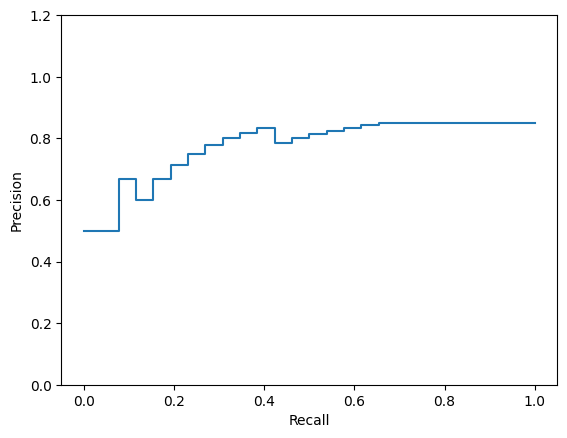

<Figure size 640x480 with 0 Axes>

In [61]:
# PRECISION-RECALL CURVE
# Calculate precision and recall values as we move down the ranked list
precision_values = [
    len([
        doc 
        for doc in results[:idx]
        if doc['Product_name'][0] in relevant
    ]) / idx 
    for idx, _ in enumerate(results, start=1)
]

recall_values = [
    len([
        doc for doc in results[:idx]
        if doc['Product_name'][0] in relevant
    ]) / len(relevant)
    for idx, _ in enumerate(results, start=1)
]

display("Precision values:", precision_values)
display("Recall values:", recall_values)

precision_recall_match = {k: v for k,v in zip(recall_values, precision_values)}


# Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
recall_values.extend([step for step in np.arange(0.0, 1.1, 0.1) if step not in recall_values])
recall_values = sorted(set(recall_values))


my_interpolated_recall = [step for step in np.arange(0.0, 1.1, 0.1)]
display("MY Interpolated Recall", my_interpolated_recall)


# Extend matching dict to include these new intermediate steps
for idx, step in enumerate(recall_values):
    if step not in precision_recall_match:
        if recall_values[idx-1] in precision_recall_match:
            precision_recall_match[step] = precision_recall_match[recall_values[idx-1]]
        else:
            precision_recall_match[step] = precision_recall_match[recall_values[idx+1]]


disp = PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)

my_interpolated_precision = [precision_recall_match.get(r) for r in my_interpolated_recall]
display("Interpolated precision", [precision_recall_match.get(r) for r in recall_values])
display("My Interpolated precision", my_interpolated_precision)


disp.plot()
plt.ylim(0, 1.2)
plt.show()
plt.savefig('precision_recall.png')
